# [MO443] Trabalho de Alinhamento de Documentos - Trabalho 03

> Trabalho realizado por Maria Angélica Krüger Miranda {197698}
>
> **Objetivo:** Implementar algoritmos de alinhamento automático de imagem de documentos

## Introdução

Um problema recorrente na análise de documentos advém do desalinhamento do texto, ou seja, quando ocorre o posicionamento da folha com uma inclinação diferente do digitalizador. Diante disso, é fundamental corrigir este problema para que sistemas de reconhecimento óptico de caracteres possam funcionar adequadamente.

Neste trabalho será explorado duas abordagens para corrigir o desalinhamento do texto. A primeira consiste na técnica de projeção horizontal e a outra na transformada de Hough. 

## Técnica Baseada em Projeção Horizontal

Esta técnica consiste variar o ângulo e projetar a quantidade de pixels pretos em cada linha do texto. O ângulo escolhido é aquele que otimiza uma certa função objetivo calculada sobre a projeção horizontal. 

Dada uma imagem que contém um texto desalinhado, o primeiro procedimento realizado será a binarização seguido da aplicação do efeito negativo na imagem, pois assim não haverá problemas com os diversos valores presentes na escala de cinza e também com o fundo preto que ficará aparente ao iniciar o processo de rotação, influenciando na contagem dos pixels pretos que pertencem aos caracteres do texto. 

O algoritmo para detectar a inclinação inicia-se percorrendo o eixo de angulação de $0$ a $180$ (variando de angulação positiva e negativa, assim percorre todos os $360°$), em que é realizado uma rotação com um determinado ângulo $\theta$ seguido do cálculo da projeção horizontal, que no caso, será a quantidade de pixels brancos, devido ao efeito negativo aplicado, presentes em cada linha da imagem. O melhor ângulo para rotacionar a imagem será aquele que produziu a menor quantidade de linhas com pixels pertencentes aos caracteres (iguais a 1), ou seja, que a maioria das linhas da imagem pertençam ao fundo. 

Nas células a seguir encontra-se os procedimentos mencionados anteriormente. Na primeira célula é realizada as importações das bibliotecas necessárias. Na célula subjacente, encontra-se quatro funções auxiliares, sendo duas que realizam a plotagem das imagens por intermédio da biblioteca *Matplotlib*, a terceira função realiza o procedimento de rotação de uma imagem com base em um ângulo e a última função realiza o processo de binarização da imagem com base num determinado limiar. Por fim, a célula seguinte contém a função de detecção do ângulo de inclinação do texto via projeção horizontal. Nesta célula contém todo o algoritmo mencionado, iniciando com o processamento da imagem (binarização e aplicação do efeito negativo) seguido da descoberta do ângulo com a projeção horizontal de maneira iterativa e com base na quantidade de linhas com pixels pertencentes aos caracteres do texto.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def mostrar_imagem(imagem, titulo, colorMap = None):
    if colorMap is not None:
        plt.imshow(imagem, cmap=colorMap)
    else:
        plt.imshow(imagem)
    plt.title(titulo)
    plt.axis('off')
    plt.show()
    
def produzir_subimagem(subimagem, i, j, imagem, color_map = None, titulo = None):
    if color_map is None:
        subimagem[i][j].imshow(imagem)
    else:
        subimagem[i][j].imshow(imagem, cmap=color_map)
    subimagem[i][j].set_title(titulo)
    subimagem[i][j].axis('off')
        

def rotacionar_imagem(imagem: np.ndarray, angulo: int):
    linhas, colunas = imagem.shape[0], imagem.shape[1]
    centro = (colunas//2, linhas//2)
    rotacao = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    img_rotacionada = cv2.warpAffine(imagem, rotacao, (colunas, linhas))
    return img_rotacionada

def binarizar_imagem(imagem: np.ndarray, limiar: int):
    imagem_binarizada = np.where(imagem > limiar, 1, 0)
    return imagem_binarizada

In [3]:
def detectar_inclinacao_projecao_horizontal(imagem: np.ndarray, limiar: int):
    
    linhas, colunas = imagem.shape[0], imagem.shape[1]
    
    # Binarização da imagem por meio de um limiar
    img_binaria = binarizar_imagem(imagem, limiar)
    
    # Aplicação do efeito negativo na imagem
    img_negativa = np.zeros((linhas, colunas), dtype=np.uint8)
    img_negativa = 1 - img_binaria
    
    # Conversão de tipo para correto funcionamento na função de rotação
    img_binaria = img_binaria.astype(np.uint8)
    img_negativa = img_negativa.astype(np.uint8)
    
    # Algoritmo de detecção de inclinação
    melhor_angulo = -180
    melhor_projecao = np.inf

    for angulo in range(0,180):
        for sinal in range(-1, 2, 2):                                           # sinal -1 ou 1 -> evitar problemas de imagem virada de cabeça para baixo e percorrer todos os ângulos    
            # Rotaciona a imagem negativa com base num determinado ângulo
            img_rotacionada = rotacionar_imagem(img_negativa, angulo*sinal)     
            
            # Determina a projeção horizontal da imagem rotacionada
            projecao_horizontal = np.zeros((linhas), dtype=np.uint8)
            for i in range(linhas):
                projecao_horizontal[i] = np.sum(np.where(img_rotacionada[i] == 1, img_rotacionada[i], 0))
            
            # Realiza a verificação para ver se vai alterar o ângulo de rotação
            qtd_linhas_nao_zeradas = np.sum(np.where(projecao_horizontal > 30, 1, 0))
            if qtd_linhas_nao_zeradas < melhor_projecao:
                melhor_projecao = qtd_linhas_nao_zeradas
                melhor_angulo = angulo*sinal
                
    return melhor_angulo

A seguinte célula aplica a técnica baseada em projeção horizontal em diversas imagens e em seguida apresenta os resultados obtidos. Foi possível observar que das sete imagens apresentadas, todas foram rotacionadas e alinhadas corretamente. Durante a execução de alguns testes foi interessante observar que a imagem *sample2.png* e *partitura.png*, sexta e sétima imagens apresentadas respectivamente, tiveram alguns cuidados adicionais. Para a primeira destas imagens, devido a presença de uma borda com mesma coloração que os caracteres, na hora de realizar a contagem de linhas que apresentam pixels associados aos caracteres foi adicionado um limiar, assim aquelas linhas que contém pixels que são da mesma cor dos caracteres, porém pertencem a borda, serão desconsiderados. Para resolver o alinhamento da segunda imagem, *partitura.png*, foi necessário aplicar um valor diferente no limiar para realizar a binarização em relação às outras imagens, para que as pautas ficassem mais vissíveis e o algoritmo de alinhamento funcionasse corretamente.

Embora este algoritmo realiza o alinhemento das imagens fornecidas, melhorias precisam ser feitas. A principal desvantagem desta implementação é o tempo de execução que acaba sendo relativamente demorado, sendo necessário aplicar melhor as técnicas de vetorização ou reestruturar a lógica principal.

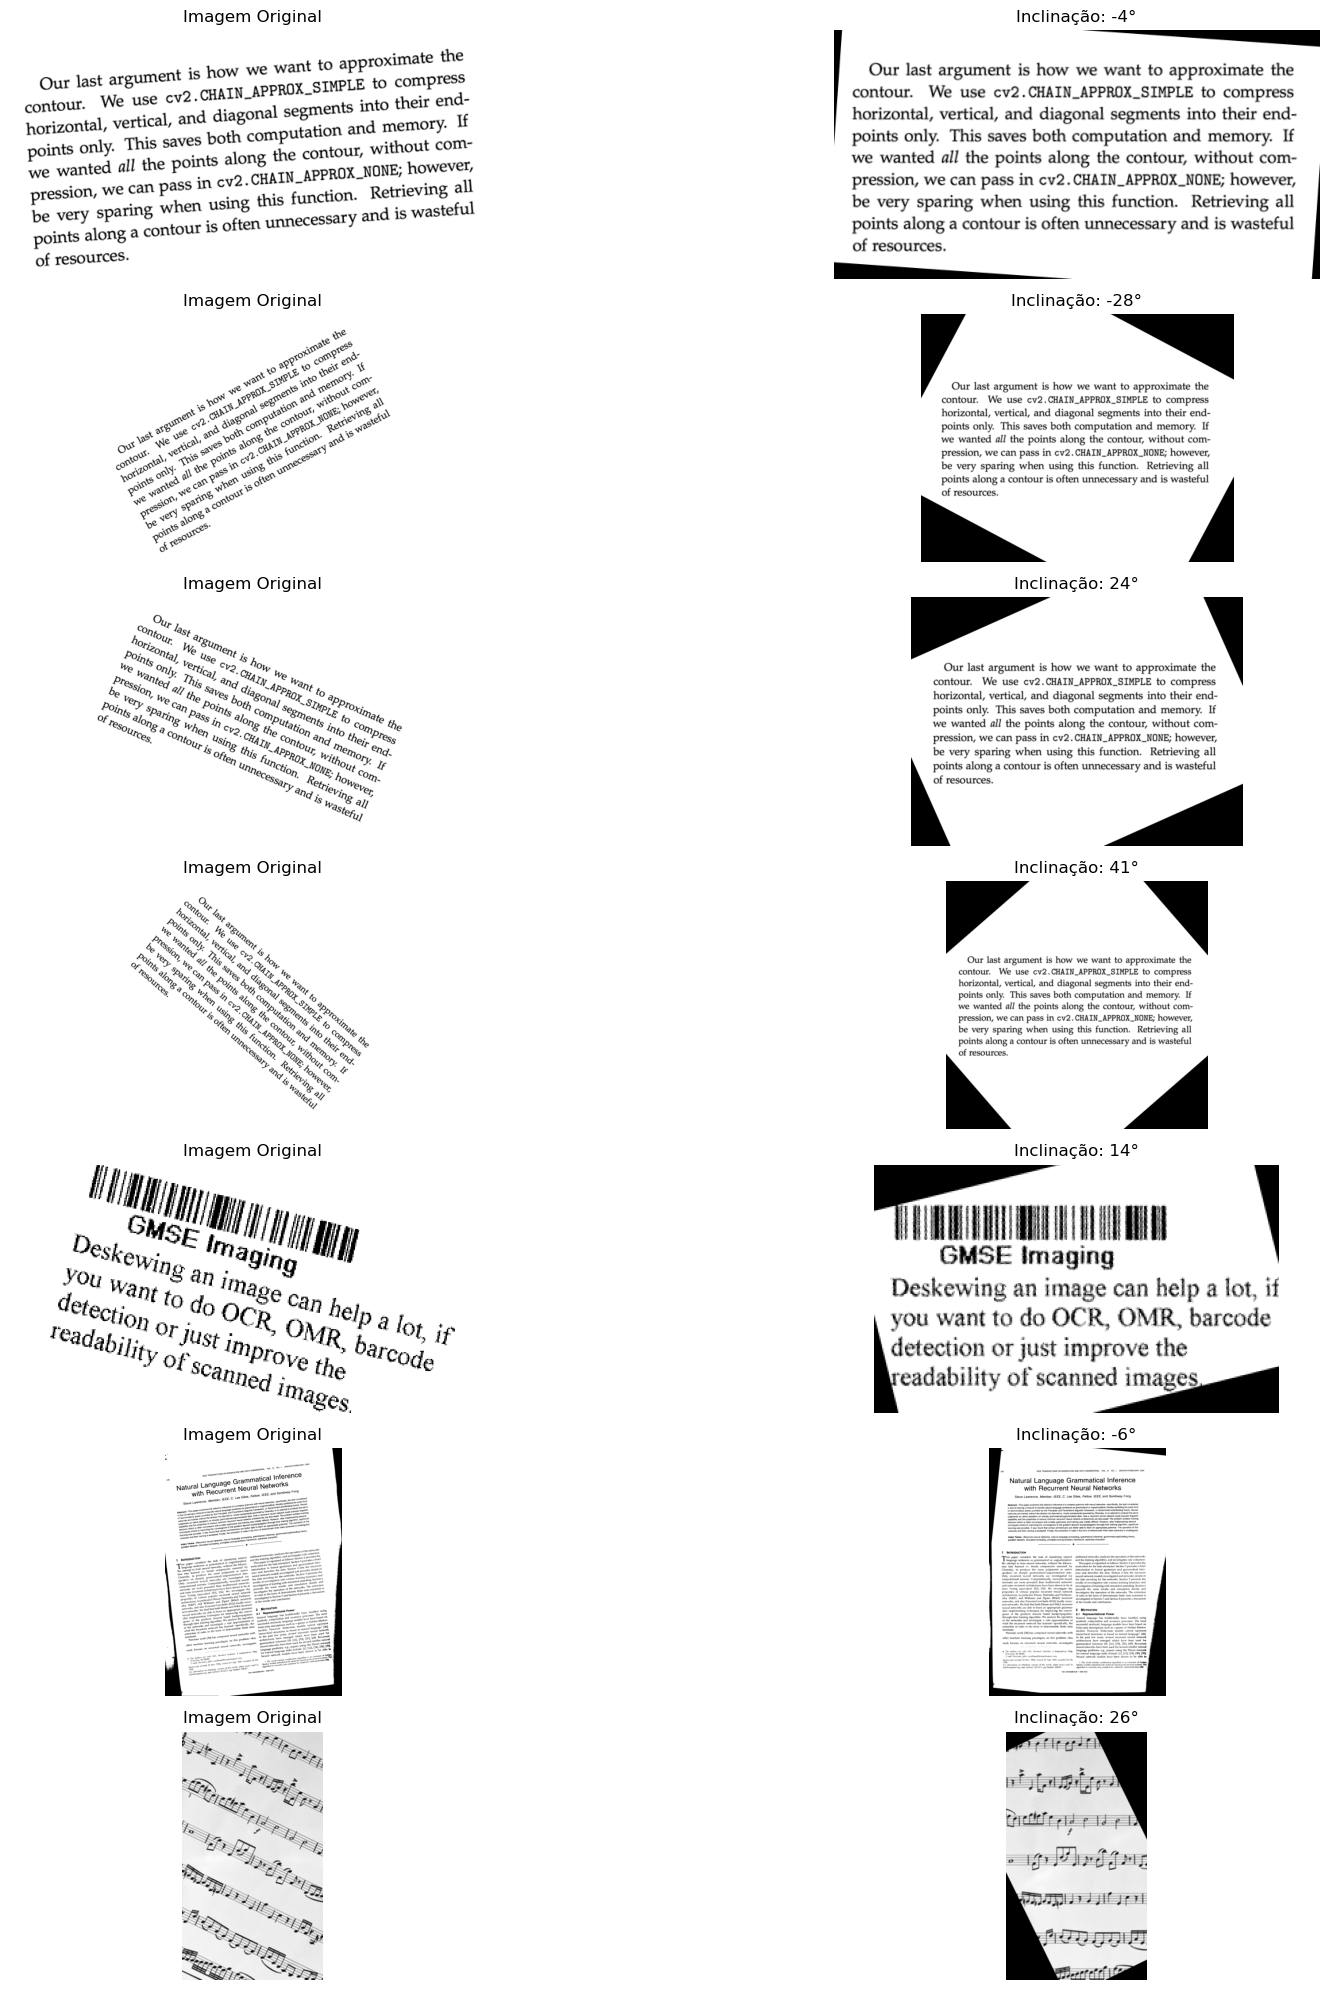

In [4]:
# Carregamento das imagens
img1 = cv2.imread('neg_4.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('neg_28.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('pos_24.png', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('pos_41.png', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('sample1.png', cv2.IMREAD_GRAYSCALE)
img6 = cv2.imread('sample2.png', cv2.IMREAD_GRAYSCALE)
img7 = cv2.imread('partitura.png', cv2.IMREAD_GRAYSCALE)
imgs = [img1, img2, img3, img4, img5, img6, img7]

# Cálculo da inclinação das imagens 
angulo1 = detectar_inclinacao_projecao_horizontal(img1, 180)
angulo2 = detectar_inclinacao_projecao_horizontal(img2, 180)
angulo3 = detectar_inclinacao_projecao_horizontal(img3, 180)
angulo4 = detectar_inclinacao_projecao_horizontal(img4, 180)
angulo5 = detectar_inclinacao_projecao_horizontal(img5, 180)
angulo6 = detectar_inclinacao_projecao_horizontal(img6, 180)
angulo7 = detectar_inclinacao_projecao_horizontal(img7, 200)
angulos = [angulo1, angulo2, angulo3, angulo4, angulo5, angulo6, angulo7]

# Apresentação das imagens originais e rotacionadas
imagens = []
titulos = []
texto = 'Imagem Original'
texto_base = 'Inclinação: '
for i in range (0,7):
    imagens.append(imgs[i])
    imagens.append(rotacionar_imagem(imgs[i], angulos[i]))
    titulos.append(texto)
    titulos.append(texto_base + str(angulos[i]) + '°')
    
fig, subimagem = plt.subplots(7, 2, figsize=(20,20))
aux=0
for i in range(0,7):
    for j in range(0,2):
        produzir_subimagem(subimagem, i, j, imagens[aux], 'gray', titulos[aux])
        aux += 1
fig.tight_layout()
plt.show()

## Técnica Baseada na Transformada de Hough

A transformada de Hough baseia-se na ideia de representar qualquer linha por meio de dois parâmetros: a distância perpendicular da origem à reta, definida por $\rho$, e o ângulo $\theta$ formado por esta linha perpendicular com o eixo horizontal medido no sentido anti-horário. Desta forma é possível representar qualquer linha por meio de $(\rho, \theta)$. Para cada pixel da imagem é possível calcular os valores de $(\rho, \theta)$, criando um sistema de coordenadas polares onde cada ponto representa uma linha presente na imagem original. Sendo assim, a transformada de Hough converte a imagem em uma matriz de $(\rho, \theta)$, chamados de acumulador. O acumulador tem valores mais altos onde muitos pixels correspondem à mesma linha e valores baixos onde há menos concordância. 

A etapas que esta técnica necessita consiste numa conversão inicial das imagens para a escala de cinza, em seguida aplicar um algoritmo de detecção de bordas, que no caso será o algoritmo de Canny, e por fim calcular aplicar a transformada de Hough, calculando a matriz acumuladora. Como é desejado realizar a correção do alinhamento do documento, não basta apenas detectar as retas da imagem, então será calculado o coeficiente angular das retas conforme o algoritmo for encontrando-as. Dado o coeficiente de inclinação de todas as retas, basta calcular uma média destes e obter o ângulo para posteriormente realizar a rotação na imagem. 

A célula a seguir realiza o processimento mencionado anteriormento. A detecção de borda foi realizada por meio da função `cv2.Canny()` juntamente com dois valores de threshold que funcionou para todas as imagens. Em seguida, a biblioteca *OpenCV* apresenta a função `cv2.HoughLines()` para realizar a transformada de Hough. Esta função retorna uma matriz acumuladora de $(\rho, \theta)$, cujos valores serão convertidos para coordenadas cartesianas seguido da obteção de dois pontos para a formação de uma reta. Com estes pontos definidos, basta calcular o coeficiente angular da reta, tomando o devido cuidado com o caso das retas verticais, uma vez que resultaria em divisão por $0$, entretanto, nestes casos a reta apresenta ângulo de inclinação de $90°$. Por fim, com todos os valores de coeficientes das retas, é calculado uma média dos mesmo seguida de uma conversão para graus, uma vez que a função `np.arctan()` retorna a angulação medida em radianos. 


In [5]:
def detectar_inclinacao_transformada_hough(imagem: np.ndarray, threshold: int = 100, max_theta=np.pi):
    angulo_rotacao = 0
    
    # Aplicação do detector de bordas de Canny
    img_borda = cv2.Canny(imagem, 150, 200)
    
    retas = cv2.HoughLines(img_borda, 1, np.pi/180, threshold, max_theta = max_theta)
    angulos = []
    for linha in retas:
        # Coordenadas polares da reta
        rho, theta = linha[0]
       
        # Conversão de coordenadas polares para cartesianas
        x = (np.cos(theta))*rho 
        y = (np.sin(theta))*rho
        
        # Cálculo dos pontos extremos da reta
        x1 = int(x + 1000*(-(np.sin(theta))))
        y1 = int(y + 1000*(np.cos(theta)))
        x2 = int(x - 1000*(-(np.sin(theta))))
        y2 = int(y - 1000*(np.cos(theta)))
        
        # Cálculo do ângulo da reta, com cuidado para o caso da reta ser vertical
        if x1 == x2:
            if y2 > y1:
                angulos.append(90)
            else:
                angulos.append(-90)
        else:
            m = (y2 - y1)/(x2 - x1)     # cálculo do coeficiente angular da reta
            angulo = np.arctan(m)       # cálculo do ângulo da reta -> m = tg(theta) -> ângulo devolvido em radianos
            angulos.append(angulo)
        
    angulo_rotacao = math.degrees(np.mean(angulos)) # cálculo da média dos ângulos das retas e conversão para graus
    
    return angulo_rotacao

A seguir é apresentado o resultado obtido após a aplicação da técnica da transformada de Hough nas mesmas sete imagens apresentadas anteriormente. Note que para cada uma delas foi necessário definir um valor de threshold único e a sexta imagem, que é um documento completo, precisou reajustar o limite superior para o ângulo para verificar linhas, uma vez que estava sendo computado linhas formadas pela diagonal dos caracteres. Além de todas as imagens serem alinhadas, é interessante observar que esta técnica foi maiz veloz que a projeção horizontal, contudo foi necessário ajustar um valor de threshold para cada imagem, diferente do anterior que apenas uma teve que ter valor distinto para realizar a binarização.

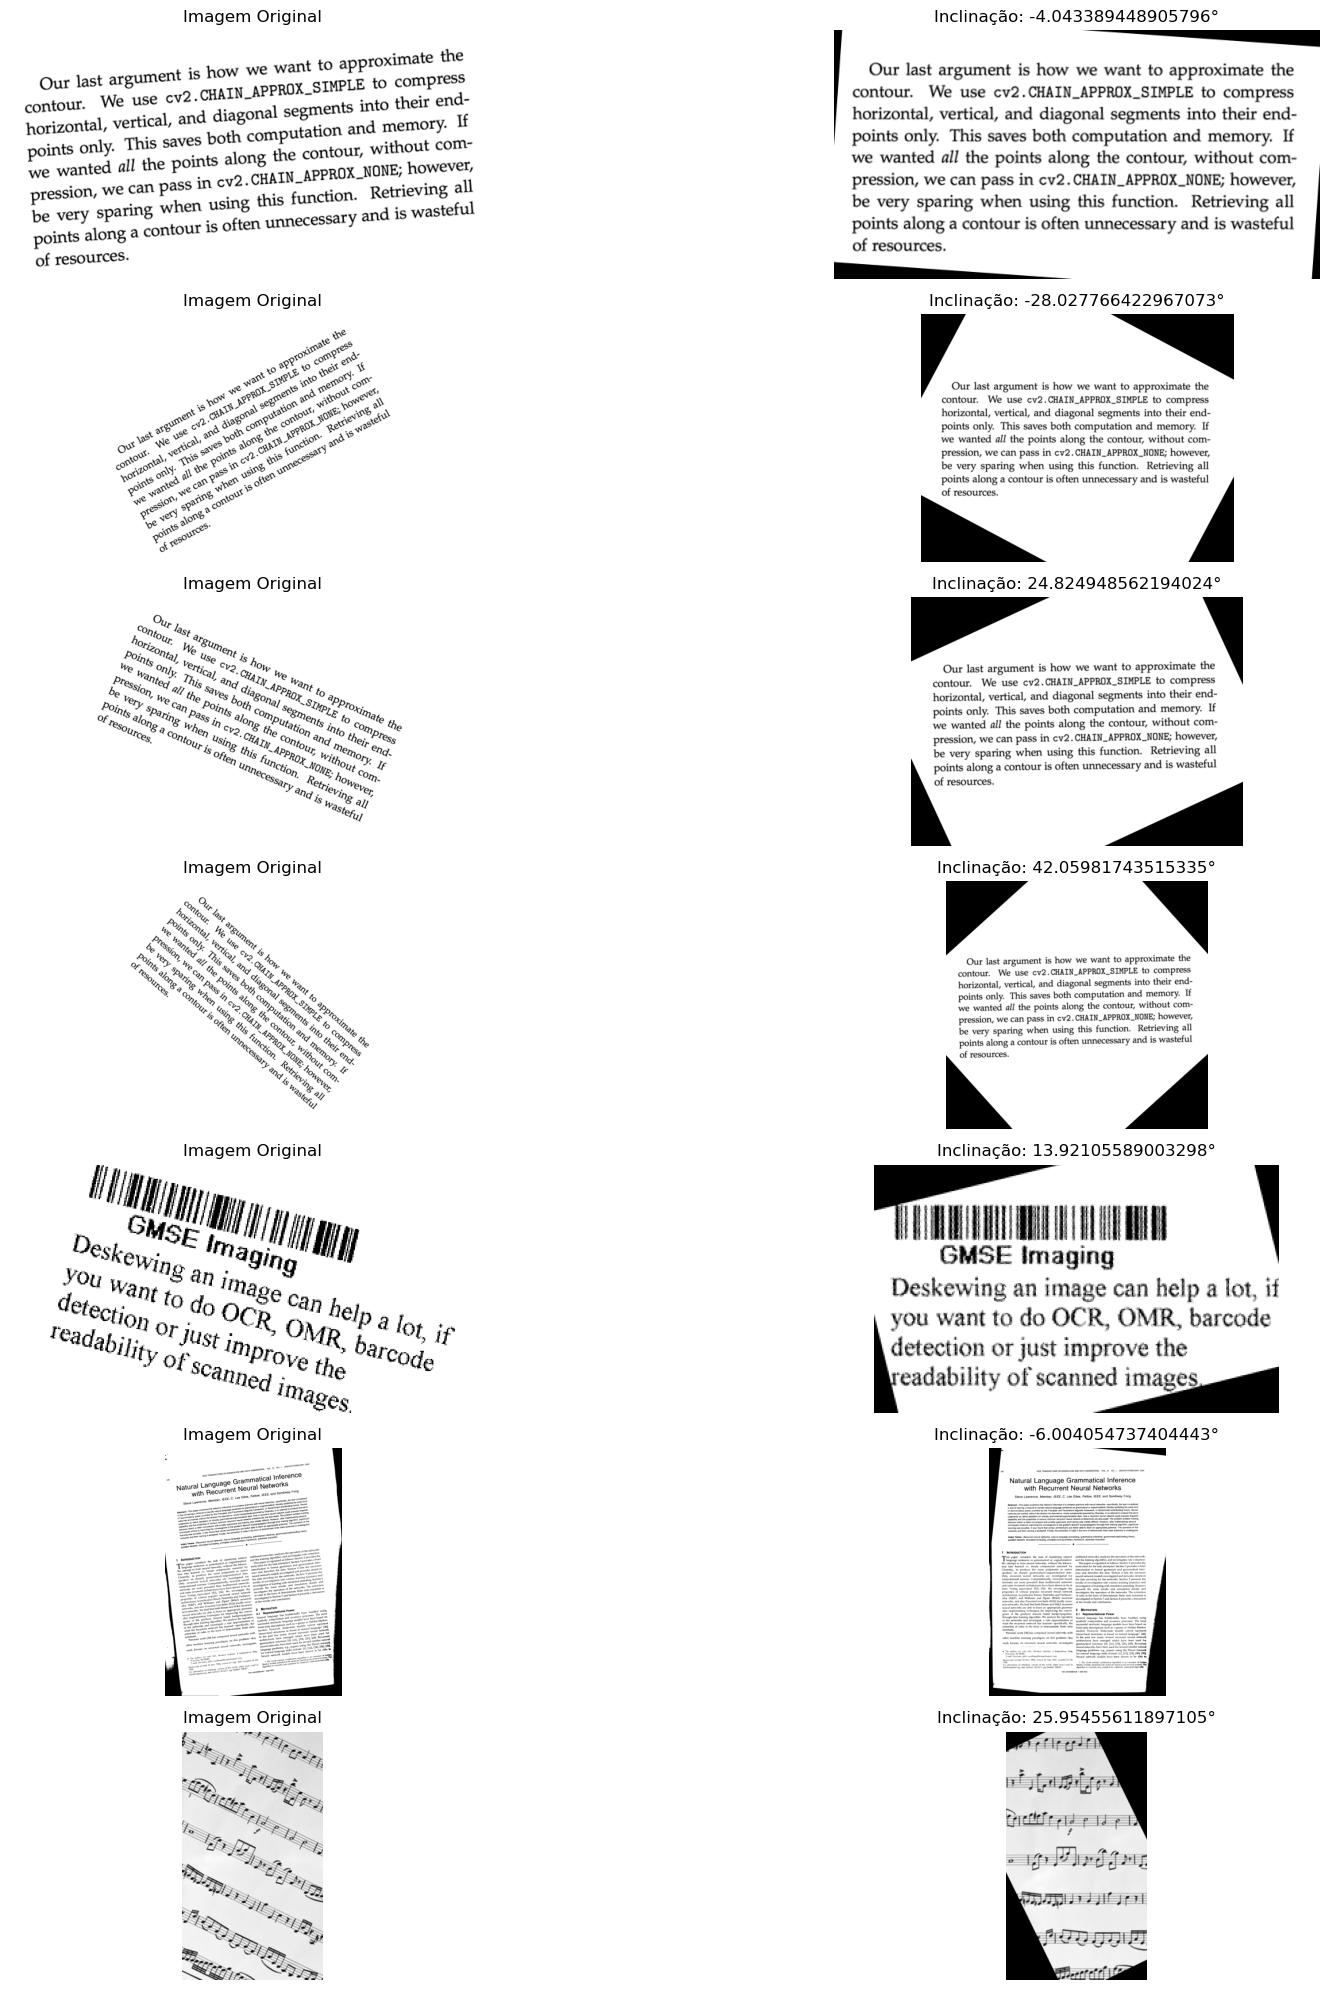

In [6]:
# Carregamento das imagens
img1 = cv2.imread('neg_4.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('neg_28.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('pos_24.png', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('pos_41.png', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('sample1.png', cv2.IMREAD_GRAYSCALE)
img6 = cv2.imread('sample2.png', cv2.IMREAD_GRAYSCALE)
img7 = cv2.imread('partitura.png', cv2.IMREAD_GRAYSCALE)
imgs = [img1, img2, img3, img4, img5, img6, img7]

# Cálculo da inclinação das imagens 
angulo1 = detectar_inclinacao_transformada_hough(img1,150)
angulo2 = detectar_inclinacao_transformada_hough(img2,180)
angulo3 = detectar_inclinacao_transformada_hough(img3,150)
angulo4 = detectar_inclinacao_transformada_hough(img4,150)
angulo5 = detectar_inclinacao_transformada_hough(img5,100)
angulo6 = detectar_inclinacao_transformada_hough(img6,245, max_theta=np.pi/2)
angulo7 = detectar_inclinacao_transformada_hough(img7,100)
angulos = [angulo1, angulo2, angulo3, angulo4, angulo5, angulo6, angulo7]

# Apresentação das imagens originais e rotacionadas
imagens = []
titulos = []
texto = 'Imagem Original'
texto_base = 'Inclinação: '
for i in range (0,7):
    imagens.append(imgs[i])
    imagens.append(rotacionar_imagem(imgs[i], angulos[i]))
    titulos.append(texto)
    titulos.append(texto_base + str(angulos[i]) + '°')
    
fig, subimagem = plt.subplots(7, 2, figsize=(20,20))
aux=0
for i in range(0,7):
    for j in range(0,2):
        produzir_subimagem(subimagem, i, j, imagens[aux], 'gray', titulos[aux])
        aux += 1
fig.tight_layout()
plt.show()